In [1]:
import numpy as np
import mne
import yasa
import pandas as pd
import xgboost as xgb

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.base import BaseEstimator, ClassifierMixin
import pickle

In [2]:
import sys
sys.path.append('../src')
from metrics import get_metrics
from plot_utils import plot_confusion_matrix, plot_hypnogram
import data_utils

# Build Dataset

In [3]:
# shortcut to build train and test set --> saves data split as dataset/train_test_set.pkl
# X_train, y_train, X_test, y_test = data_utils.build_train_test_set()

In [4]:
# to load train and test set directly from pickle:
X_train, y_train, X_test, y_test = data_utils.load_train_test_set()

In [5]:
# LEFT FOR REFERENCE:
# File paths for labels
label_paths1 = [f"../dataset/{i}/{i}_1.txt" for i in range(1, 11)]
label_paths2 = [f"../dataset/{i}/{i}_2.txt" for i in range(1, 11)]

# Load and preprocess labels
labels1 = data_utils.load_and_preprocess_labels(label_paths1)
labels2 = data_utils.load_and_preprocess_labels(label_paths2)

In [6]:
# File paths for EDF data
edf_paths = [f"../dataset/{i}/{i}.edf" for i in range(1, 11)]

# Channels to drop
channels_to_drop = ['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8', 'ROC-A1', 
                    'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'O2-A1', 'X2', 'X3']

# Load and preprocess EDF data
edf_features = data_utils.load_and_preprocess_edf(
    edf_paths, channels_to_drop, eeg_name='C4-A1', eog_name='LOC-A2', emg_name='X1'
)

Extracting EDF parameters from c:\Machine Learning\Master Tuebingen\Semester_3\HDA\sleep-stage-detection\dataset\1\1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5723999  =      0.000 ... 28619.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 1101 samples (11.010 s)

Extracting EDF parameters from c:\Machine Learning\Master Tuebingen\Semester_3\HDA\sleep-stage-detection\dataset\2\2.edf...
EDF file detected
Setting channel info structur

In [7]:
df = pd.concat(edf_features, axis=0, ignore_index=True)
df['label'] = labels1
df

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm,patient,label
0,2.223068,0.204966,0.002076,0.306459,0.378508,0.849507,4.183846,0.938656,2.029363,0.126726,...,3.658173,1.719663,2.068285,0.027003,-0.753603,-0.772851,0.000000,0.000000,1,0
1,1.739309,0.187676,-0.035666,0.214499,0.363193,0.644535,1.858936,0.838479,1.347365,0.142990,...,2.873480,1.567306,1.747598,0.048089,-0.751319,-0.699733,0.008333,0.001049,1,0
2,10.646273,0.178649,0.415034,0.053756,0.354735,0.337353,1.102060,0.774777,0.972015,0.103112,...,3.556994,1.419040,1.826927,0.042671,-0.753057,-0.687887,0.016667,0.002099,1,0
3,3.218050,0.118178,0.350609,0.125759,0.373581,0.264007,1.339224,0.733314,0.819126,0.195343,...,2.967387,1.242866,1.746112,0.048401,-0.756539,-0.672028,0.025000,0.003148,1,0
4,1.839396,0.060042,0.335642,0.145482,0.400621,0.084603,1.453737,0.701424,0.418695,0.268479,...,2.672432,1.056105,1.544686,0.039588,-0.762816,-0.650208,0.033333,0.004197,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8584,1.689531,0.083630,0.166005,0.054617,0.042170,-0.040508,0.309166,-0.037917,-0.024846,0.012473,...,1.162780,-0.044361,-0.024150,0.124126,0.052475,0.035126,6.341667,0.957233,10,3
8585,0.827841,0.060448,0.132634,0.112396,0.080795,0.005466,0.447176,-0.022316,-0.102220,0.037533,...,0.938274,-0.043509,-0.029735,0.265009,0.063362,0.196317,6.350000,0.958491,10,3
8586,0.969841,0.041204,0.110130,0.066259,0.106981,-0.059442,0.373438,-0.005168,-0.185313,0.023099,...,0.980872,-0.038315,-0.041812,0.135848,0.042102,0.174866,6.358333,0.959748,10,3
8587,1.027211,0.025514,0.078914,0.126245,0.131536,0.155500,0.877514,0.014709,0.090224,0.084172,...,2.469572,0.011695,0.080303,0.053560,0.012319,0.027808,6.366667,0.961006,10,0


For information of created features:
https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html

Interesting Comment:
N1 sleep is the sleep stage with the lowest detection accuracy. This is expected because N1 is also the stage with the lowest human inter-rater agreement. Be very careful for potential misclassification of N1 sleep (e.g. scored as Wake or N2) when inspecting the predicted sleep stages.

In [8]:
df_train = df.loc[df['patient'].between(1, 8)].copy()
df_test = df.loc[df['patient'].between(9, 10)].copy()

y_train = df_train['label'].copy()
X_train = df_train.drop(columns=['label']).copy()

y_test = df_test['label'].copy()
X_test = df_test.drop(columns=['label']).copy()

In [9]:
print("Label distribution in y_train:")
print(y_train.value_counts(normalize=True).sort_index())
print("\nLabel distribution in y_test:")
print(y_test.value_counts(normalize=True).sort_index())

Label distribution in y_train:
label
0    0.207002
1    0.120715
2    0.302295
3    0.243899
4    0.126089
Name: proportion, dtype: float64

Label distribution in y_test:
label
0    0.146041
1    0.226393
2    0.313783
3    0.197654
4    0.116129
Name: proportion, dtype: float64


In [10]:
classes=[0, 1, 2, 3, 4]
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

# Sklearn HistGradientBoostingClassifier

In [11]:
clf = HistGradientBoostingClassifier()
clf.fit(X_train, y_train)
df_test['preds_sklearn'] = clf.predict(X_test)
# df_train['preds_sklearn'] = clf.predict(X_train)

# print("TRAINING SET PERFORMANCE \n")
# metrics_sklearn = get_metrics(df_train['label'], df_train['preds_sklearn'], classes, normalize='true')
print("\n\n TEST SET PERFORMANCE") 
metrics_sklearn = get_metrics(df_test['label'], df_test['preds_sklearn'], classes, normalize='true')
# plot_hypnogram(df_test['label'], df_test['preds_sklearn'])



 TEST SET PERFORMANCE
Accuracy: 0.7848
Balanced Accuracy: 0.7947

Confusion Matrix:
[[0.80722892 0.15662651 0.03614458 0.         0.        ]
 [0.14766839 0.64248705 0.16062176 0.         0.0492228 ]
 [0.02616822 0.13457944 0.77943925 0.04859813 0.01121495]
 [0.         0.         0.08902077 0.91097923 0.        ]
 [0.         0.05050505 0.11111111 0.00505051 0.83333333]]

Detailed Classification Metrics:
   Class  Precision    Recall  F1-Score  Support       AUC
0      0   0.738971  0.807229  0.771593      249  0.879233
1      1   0.672087  0.642487  0.656954      386  0.775375
2      2   0.772222  0.779439  0.775814      535  0.837156
3      3   0.919162  0.910979  0.915052      337  0.945621
4      4   0.868421  0.833333  0.850515      198  0.908372

Average Metrics:
Avg Precision: 0.7942
Avg Recall: 0.7947
Avg F1-Score: 0.7940
Avg AUC: 0.8692


In [11]:
config = {
'learning_rate': clf.learning_rate,
'max_iter': clf.max_iter,
'max_depth': clf.max_depth,
'max_leaf_nodes': clf.max_leaf_nodes,
'min_samples_leaf': clf.min_samples_leaf,
'l2_regularization': clf.l2_regularization,
'max_bins': clf.max_bins
}
config

{'learning_rate': 0.1,
 'max_iter': 100,
 'max_depth': None,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'l2_regularization': 0.0,
 'max_bins': 255}

In [ ]:
from model import log_model_to_mlflow
import mlflow
mlflow.set_tracking_uri('../mlruns')

log_model_to_mlflow(clf, metrics_sklearn, X_train, run_name="HistGradientBoost_DefaultExperiment")

2025/01/21 01:18:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


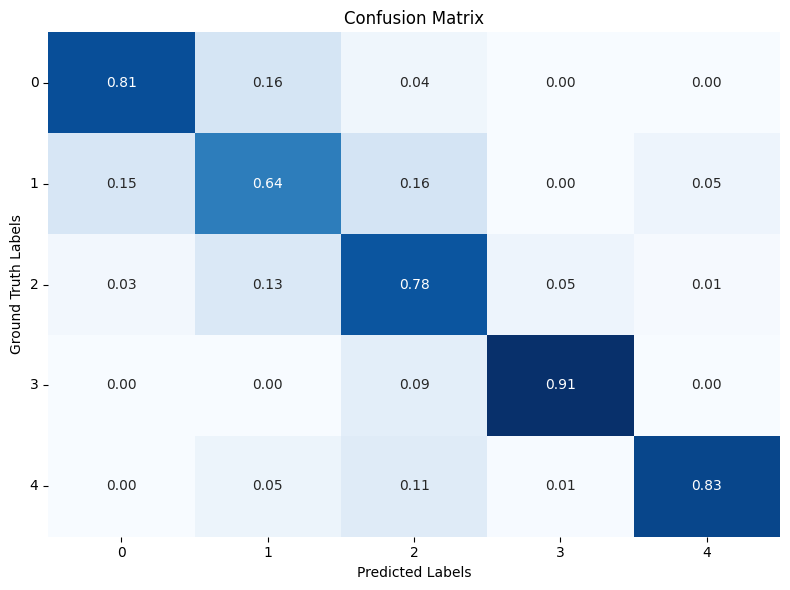

In [13]:
plot_confusion_matrix(metrics_sklearn['conf_matrix'], classes, normalize='true')

In [15]:
clf_weighted = HistGradientBoostingClassifier().fit(X_train, y_train, sample_weight=sample_weights)
df_test['preds_sklearn_weighted'] = clf_weighted.predict(X_test)

metrics_sklearn = get_metrics(df_test['label'], df_test['preds_sklearn_weighted'], classes, normalize='true')
# plot_hypnogram(df_test['label'], df_test['preds_sklearn_weighted'])

Accuracy: 0.7806
Balanced Accuracy: 0.7917

Confusion Matrix:
[[0.80722892 0.16465863 0.01606426 0.00401606 0.00803213]
 [0.15803109 0.66321244 0.12953368 0.         0.0492228 ]
 [0.02990654 0.15514019 0.75700935 0.04485981 0.01308411]
 [0.         0.         0.09198813 0.90801187 0.        ]
 [0.         0.06565657 0.10606061 0.00505051 0.82323232]]

Detailed Classification Metrics:
   Class  Precision    Recall  F1-Score  Support       AUC
0      0   0.723022  0.807229  0.762808      249  0.877172
1      1   0.651399  0.663212  0.657253      386  0.779673
2      2   0.792564  0.757009  0.774379      535  0.833206
3      3   0.921687  0.908012  0.914798      337  0.944503
4      4   0.853403  0.823232  0.838046      198  0.902326

Average Metrics:
Avg Precision: 0.7884
Avg Recall: 0.7917
Avg F1-Score: 0.7895
Avg AUC: 0.8674


In [ ]:
plot_confusion_matrix(metrics_sklearn['conf_matrix'], classes, normalize='true')

In [18]:
ovr_clf = OneVsRestClassifier(HistGradientBoostingClassifier()).fit(X_train, y_train)
df_test['preds_sklearn_ovr'] = ovr_clf.predict(X_test)

metrics_xgb = get_metrics(df_test['label'], df_test['preds_sklearn_ovr'], classes)
# plot_hypnogram(df_test['label'], df_test['preds_sklearn_ovr'])

Accuracy: 0.7801
Balanced Accuracy: 0.7946

Confusion Matrix:
[[204  36   7   0   2]
 [ 65 235  62   1  23]
 [ 18  70 409  30   8]
 [  0   0  23 314   0]
 [  0   3  26   1 168]]

Detailed Classification Metrics:
   Class  Precision    Recall  F1-Score  Support       AUC
0      0   0.710801  0.819277  0.761194      249  0.881136
1      1   0.683140  0.608808  0.643836      386  0.763085
2      2   0.776091  0.764486  0.770245      535  0.831816
3      3   0.907514  0.931751  0.919473      337  0.954179
4      4   0.835821  0.848485  0.842105      198  0.913294

Average Metrics:
Avg Precision: 0.7827
Avg Recall: 0.7946
Avg F1-Score: 0.7874
Avg AUC: 0.8687


# XGBoost XGBClassifier

In [19]:
clf = xgb.XGBClassifier(num_class=5, objective='multi:softmax', eval_metric='mlogloss').fit(X_train, y_train)
df_test['preds_xgb'] = clf.predict(X_test)

metrics_xgb = get_metrics(df_test['label'], df_test['preds_xgb'], classes)
# plot_hypnogram(df_test['label'], df_test['preds_xgb'])

Accuracy: 0.7812
Balanced Accuracy: 0.7917

Confusion Matrix:
[[200  42   6   0   1]
 [ 66 239  61   0  20]
 [ 17  65 424  22   7]
 [  0   0  36 300   1]
 [  0   5  23   1 169]]

Detailed Classification Metrics:
   Class  Precision    Recall  F1-Score  Support       AUC
0      0   0.706714  0.803213  0.751880      249  0.873104
1      1   0.680912  0.619171  0.648575      386  0.767129
2      2   0.770909  0.792523  0.781567      535  0.842416
3      3   0.928793  0.890208  0.909091      337  0.936697
4      4   0.853535  0.853535  0.853535      198  0.917146

Average Metrics:
Avg Precision: 0.7882
Avg Recall: 0.7917
Avg F1-Score: 0.7889
Avg AUC: 0.8673


In [25]:
clf_weighted = xgb.XGBClassifier(num_class=5, objective='multi:softmax', eval_metric='mlogloss').fit(X_train, y_train, sample_weight=sample_weights)
df_test['preds_xgb_weighted'] = clf_weighted.predict(X_test)

metrics_xgb = get_metrics(df_test['label'], df_test['preds_xgb_weighted'], classes)
# plot_hypnogram(df_test['label'], df_test['preds_xgb_weighted'])

Accuracy: 0.7754

Confusion Matrix:
[[202  40   6   0   1]
 [ 66 238  60   0  22]
 [ 18  81 411  21   4]
 [  0   0  31 306   0]
 [  0   8  25   0 165]]

Detailed Classification Metrics:
   Class  Precision    Recall  F1-Score  Support
0      0   0.706294  0.811245  0.755140      249
1      1   0.648501  0.616580  0.632138      386
2      2   0.771107  0.768224  0.769663      535
3      3   0.935780  0.908012  0.921687      337
4      4   0.859375  0.833333  0.846154      198


In [26]:
class SklearnCompatibleXGBClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = xgb.XGBClassifier(**kwargs)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)

ovr_clf = OneVsRestClassifier(SklearnCompatibleXGBClassifier(objective='binary:logistic', eval_metric='logloss')).fit(X_train, y_train)
df_test['preds_xgb_ovr'] = ovr_clf.predict(X_test)

metrics_xgb = get_metrics(df_test['label'], df_test['preds_xgb_ovr'], classes)
# plot_hypnogram(df_test['label'], df_test['preds_xgb_ovr'])


Accuracy: 0.7865

Confusion Matrix:
[[200  42   7   0   0]
 [ 61 241  62   1  21]
 [ 12  67 427  22   7]
 [  0   0  34 303   0]
 [  0   5  23   0 170]]

Detailed Classification Metrics:
   Class  Precision    Recall  F1-Score  Support
0      0   0.732601  0.803213  0.766284      249
1      1   0.678873  0.624352  0.650472      386
2      2   0.772152  0.798131  0.784926      535
3      3   0.929448  0.899110  0.914027      337
4      4   0.858586  0.858586  0.858586      198


# Yasa Predictor

In [27]:
edf_paths = [f"../dataset/{i}/{i}.edf" for i in range(9, 11)]

preds_sls = []

for path in edf_paths:
    raw = mne.io.read_raw_edf(path, preload=True)
    raw.drop_channels(['X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'O2-A1', 'X2', 'X3'])
    raw.resample(100)
    raw.filter(0.3, 49)
    sls = yasa.SleepStaging(raw, eeg_name ='C4-A1' ,  eog_name='LOC-A2', emg_name='X1')
    preds_sls.extend(yasa.hypno_str_to_int(sls.predict()[:-30]))

df_test['preds_sls'] = preds_sls

Extracting EDF parameters from c:\Machine Learning\Master Tuebingen\Semester_3\HDA\sleep-stage-detection\dataset\9\9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5813999  =      0.000 ... 29069.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 1101 samples (11.010 s)

Extracting EDF parameters from c:\Machine Learning\Master Tuebingen\Semester_3\HDA\sleep-stage-detection\dataset\10\10.edf...
EDF file detected
Setting channel info struct

c:\Machine Learning\Master Tuebingen\Semester_3\HDA\.venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 1101 samples (11.010 s)



c:\Machine Learning\Master Tuebingen\Semester_3\HDA\.venv\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [17]:
metrics_sls = get_metrics(df_test['label'], df_test['preds_sls'], classes)
# plot_hypnogram(df_test['label'], df_test['preds_sls'])

Accuracy: 0.4516

Confusion Matrix:
[[238   4   5   0   2]
 [248  88  34   0  16]
 [185  47 300   0   3]
 [ 92   2 230  13   0]
 [ 28  34   5   0 131]]

Detailed Classification Metrics:
   Class  Precision    Recall  F1-Score  Support
0      0   0.300885  0.955823  0.457692      249
1      1   0.502857  0.227979  0.313725      386
2      2   0.522648  0.560748  0.541028      535
3      3   1.000000  0.038576  0.074286      337
4      4   0.861842  0.661616  0.748571      198
